In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'asthma_disease_data.csv'
asthma_data = pd.read_csv(file_path)

In [3]:
one_hot_encoder = OneHotEncoder(sparse=False)
doctor_encoded = one_hot_encoder.fit_transform(asthma_data[['DoctorInCharge']])
doctor_encoded_df = pd.DataFrame(doctor_encoded, columns=one_hot_encoder.get_feature_names_out(['DoctorInCharge']))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
asthma_data = asthma_data.drop('DoctorInCharge', axis=1)
asthma_data = pd.concat([asthma_data, doctor_encoded_df], axis=1)

In [5]:
numerical_features = ['Age', 'BMI', 'PhysicalActivity', 'SleepQuality','LungFunctionFEV1', 'LungFunctionFVC']

In [6]:
scaler = StandardScaler()
asthma_data[numerical_features] = scaler.fit_transform(asthma_data[numerical_features])

In [7]:
asthma_data['BMI_Age'] = asthma_data['BMI'] * asthma_data['Age']
asthma_data['PA_Sleep'] = asthma_data['PhysicalActivity'] * asthma_data['SleepQuality']
asthma_data['MeanLungFunction'] = (asthma_data['LungFunctionFEV1'] + asthma_data['LungFunctionFVC']) / 2
asthma_data['HighRisk'] = ((asthma_data['BMI'] > 25) & (asthma_data['Age'] > 60)).astype(int)
asthma_data['AgeGroup'] = pd.cut(asthma_data['Age'], bins=[0, 18, 35, 50, 65, 100], labels=['Child', 'YoungAdult', 'Adult', 'MiddleAge', 'Senior'])

In [8]:
X = asthma_data.drop(['PatientID', 'Diagnosis'], axis=1)
y = asthma_data['Diagnosis']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
X_train = pd.get_dummies(X_train, columns=['AgeGroup'])
X_test = pd.get_dummies(X_test, columns=['AgeGroup'])

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [15]:
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [18]:
tsne = TSNE(n_components=2, random_state=42)

X_train_tsne = tsne.fit_transform(X_train)

X_combined = pd.concat([X_train, X_test])
X_combined_tsne = tsne.fit_transform(X_combined)

X_test_tsne = X_combined_tsne[len(X_train):]

In [19]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

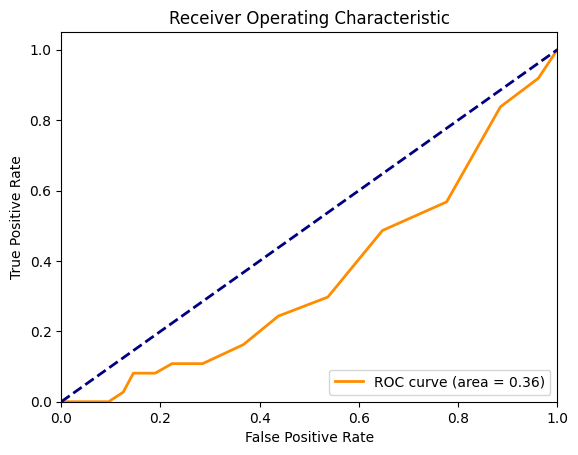

In [22]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[681   0]
 [ 37   0]]
Accuracy: 0.9484679665738162
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [24]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 0.05153203342618384
Root Mean Squared Error: 0.22700668145714092
R-squared: -0.05433186490455233


In [25]:
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters (Grid Search):", grid_search.best_params_)

Best Parameters (Grid Search): {'max_depth': None, 'n_estimators': 100}


In [26]:
param_dist = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
print("Best Parameters (Random Search):", random_search.best_params_)

Best Parameters (Random Search): {'n_estimators': 100, 'max_depth': 30}
